In [ ]:
#In this work, the 171 electrode's channels are considered as nodes, and edges are the respective connections.
#For the creation and study of complex networks, we used the package NetworkX.
#We considered the PSD of the data over the entire 0-150 Hz range, obtaining just one network describing the correlation of channels over the entire frequency range.
#Neural interactions have been assessed computing the Pearson correlation coefficient (Pcc), using the pearsonr function from the scipy.stats library.
#We performed the Bonferroni test, using the statsmodels.stats.multitest.multipletests function, in order to eliminate multiple spurious positives.  Once the corrected Pcc was calculated, we built the adjacency matrix (M).
#For each network we computed different centrality measures and we performed a Mann-Whitney U test, computing the normalized statistic for each measure to assess their effectiveness in distinguishing between epileptic and non-epileptic channels.

#In a parallel analysis, we used the Louvain algorithm to cluster the nodes in order to assess how distinctly the networks separated epileptic from non-epileptic channels. To measure the goodness of our clustering algorithm, we computed the v_measure_score which is a symmetric metric corresponding to the harmonic mean between homogeneity and completeness.
#We used this metric in order to evaluate:
#-how well the predicted clusters represent the epileptogenic and non-epileptogenic classes.
#-the connection between the predicted clusters and the electrodes. This should ideally be similar to the relationship between actual epileptogenic and non-epileptogenic classes and the electrodes.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import csv
from scipy.optimize import curve_fit
from scipy.fft import fft
from scipy import signal
from scipy.signal import iirnotch, lfilter
from scipy.signal import butter, filtfilt
import os
import networkx as nx
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.multitest import multipletests
from scipy.signal import find_peaks
import statistics
from scipy.signal import peak_widths
from sklearn.metrics import mutual_info_score
import matplotlib.patches as mpatches
from scipy.signal import butter, lfilter
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import networkx as nx
from community import community_louvain
from networkx.algorithms import community
from matplotlib.colors import ListedColormap
from sklearn.metrics import homogeneity_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import v_measure_score
from scipy.stats import mannwhitneyu, norm



In [ ]:
#GRAPHIC SETTINGS
sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rcParams['lines.linewidth'] = 0.5
plt.rc('font', size=13)          # controls default text sizes

def divide_in_seconds(data, sample_rate):   #funzione valida anche per dividere le frequenze
    samples_per_second = sample_rate
    # Divido ciascun array in sottoliste di 'samples_per_second' elementi
    divided_data = [data[i:i+samples_per_second] for i in range(0, len(data), samples_per_second)]

    return divided_data

# Funzione per salvare ogni array in un file CSV separato
def save_arrays_to_csv(arrays,file_name,folder):
    csv_file_name = f'{folder}/{file_name}.csv'
    with open(csv_file_name, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            writer.writerow([file_name])
            writer.writerows([[value] for value in arrays[0:]])



In [ ]:
folder_path_0 = 'psd_non_epi'
folder_path_1 = 'psd_epi'
folder_path_freq = 'freq'

NON_EPI = []
NON_EPIcsv = []
EPI = []
EPIcsv = []
labels_0 = []
labels_1 = []

filenames_0 = [f for f in os.listdir(folder_path_0) if os.path.isfile(os.path.join(folder_path_0, f))]
filenames_1 = [f for f in os.listdir(folder_path_1) if os.path.isfile(os.path.join(folder_path_1, f))]

for filename_0 in filenames_0:
    file_path_0 = os.path.join(folder_path_0, filename_0)
    file_name = os.path.splitext(os.path.basename(file_path_0))[0]
    labels_0.append(file_name)
    df_0 = pd.read_csv(file_path_0)
    col_1=df_0.columns[1]
    array_0 = df_0[col_1].values
    NON_EPI.append(array_0)

for filename_1 in filenames_1:
    file_path_1 = os.path.join(folder_path_1, filename_1)
    file_name = os.path.splitext(os.path.basename(file_path_1))[0]
    labels_1.append(file_name)
    df_1 = pd.read_csv(file_path_1)
    col_1=df_1.columns[1]
    array_1 = df_1[col_1].values
    EPI.append(array_1)
    col_0=df_1.columns[0]
    freq = df_1[col_0].values

data_unsorted=NON_EPI+EPI
labels=labels_0+labels_1

combined = list(zip(labels, data_unsorted))
combined_sorted = sorted(combined, key=lambda x: x[0])
labels_tot, data = zip(*combined_sorted)
labels_tot = list(labels_tot)
data = list(data)

Fs = 500.0
Ts = 1.0/Fs
len_data_array=len(data[0])
print("numeri di misure per ogni canale:",len_data_array)
print(freq)
print(labels_tot)
print(data[1])

cartella = "frequency_domain_network_output(psd)"
os.makedirs(cartella, exist_ok=True)

numeri di misure per ogni canale: 501
[  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5
  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5
  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5
  30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5
  36.   36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5
  42.   42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5
  48.   48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5
  54.   54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5
  60.   60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5
  66.   66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5
  72.   72.5  73.   73.5  74.   74.5  75.   75.5  76.   76.5  77.   77.5
  78.   78.5 

In [ ]:
# Plot FFT dei dati filtrati
plt.figure(figsize=(10, 6))
plt.plot(freq,data[0])
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Amplitude (μV)')
plt.xlim(0,170)
plt.grid(True)
plt.show()

In [ ]:
my_range=freq
divided_fft=data
interval_data = [array for array in divided_fft]
correlations = []
p_values = []
for i in range(len(interval_data)):
    for j in range(i+1, len(interval_data)):
        corr, p = pearsonr(interval_data[i], interval_data[j])
        correlations.append(corr)
        p_values.append(p)

reject, corrected_p_values, _, alpha_2 = multipletests(p_values, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
adjacency_matrix = np.zeros((len(interval_data),len(interval_data)))
k = 0
for i in range(len(interval_data)):
    for j in range(i+1, len(interval_data)):
        if reject[k]:  # Se la correlazione è significativa
            adjacency_matrix[i, j] = correlations[k]
            adjacency_matrix[j, i] = correlations[k]
        k += 1

# Crea il network con NetworkX
G = nx.from_numpy_array(adjacency_matrix)
labels_dict = {i: label for i, label in enumerate(labels_tot)}
nx.set_node_attributes(G, labels_dict, 'label')

os.makedirs("adjacency_matrices", exist_ok=True)
np.save("adjacency_matrices/adjacency_matrix_psd.npy", adjacency_matrix)

In [ ]:
#CARICO LE MATRICI DI ADIACENZA SALVATE
adjacency_matrix = np.load("adjacency_matrices/adjacency_matrix_psd.npy", allow_pickle=True)

['A1', 'A10', 'A11', 'A12', 'A13', 'A14', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'F1', 'F10', 'F11', 'F12', 'F2', 'F3', 'F6', 'F7', 'F8', 'F9', 'G1', 'G10', 'G11', 'G12', 'G13', 'G14', 'G2', 'G3', 'G4', 'H1', 'H10', 'H11', 'H12', 'H2', 'H3', 'H4', 'H7', 'H8', 'H9', 'I1', 'I10', 'I2', 'I3', 'I7', 'I8', 'I9', 'J1', 'J14', 'J15', 'J16', 'J17', 'J18', 'J2', 'J3', 'J4', 'J5', 'L1', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'M1', 'M15', 'M16', 'M17', 'M2', 'M3', 'M4', 'M5', 'N1', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18', 'N2', 'N3', 'N4', 'N5', 'N6', 'O1', 'O10', 'O11', 'O12', 'O13', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'R1', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R2', 'R3', 'R7', 'R8', 'R9', 'T1', 'T2', 'T3', 'T4', 'X1', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X2', 'X3', 'X4', 'X5', 'X6', 'Y1', 'Y10', 'Y11', 'Y2', 'Y5', 'Y6', 'Y7', 'Y8'

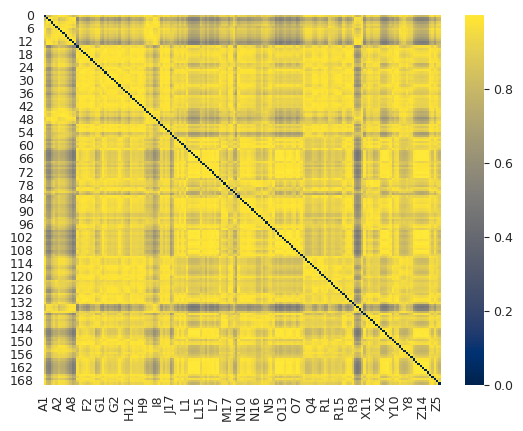

In [ ]:
data=pd.DataFrame(adjacency_matrix, columns=labels_tot)
sns.heatmap(data, cmap='cividis')

print(labels_tot)

In [ ]:
labels_true = []
for label in labels_tot:
    if label in labels_0:
        labels_true.append(0)
    else:
        labels_true.append(1)
print(labels_tot)
print(labels_true)

# Dizionario che associa ogni lettera a un numero
letter_to_number = {
    'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5,
    'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10,
    'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15,
    'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20,
    'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26
}

# Creazione del nuovo array con i numeri corrispondenti
labels_electrodes = [letter_to_number[label[0].upper()] for label in labels_tot]

print(labels_electrodes)
print(labels_0)
print(labels_1)

labels_dict = {i: label for i, label in enumerate(labels_tot)}



['A1', 'A10', 'A11', 'A12', 'A13', 'A14', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'F1', 'F10', 'F11', 'F12', 'F2', 'F3', 'F6', 'F7', 'F8', 'F9', 'G1', 'G10', 'G11', 'G12', 'G13', 'G14', 'G2', 'G3', 'G4', 'H1', 'H10', 'H11', 'H12', 'H2', 'H3', 'H4', 'H7', 'H8', 'H9', 'I1', 'I10', 'I2', 'I3', 'I7', 'I8', 'I9', 'J1', 'J14', 'J15', 'J16', 'J17', 'J18', 'J2', 'J3', 'J4', 'J5', 'L1', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'M1', 'M15', 'M16', 'M17', 'M2', 'M3', 'M4', 'M5', 'N1', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18', 'N2', 'N3', 'N4', 'N5', 'N6', 'O1', 'O10', 'O11', 'O12', 'O13', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'R1', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16', 'R2', 'R3', 'R7', 'R8', 'R9', 'T1', 'T2', 'T3', 'T4', 'X1', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X2', 'X3', 'X4', 'X5', 'X6', 'Y1', 'Y10', 'Y11', 'Y2', 'Y5', 'Y6', 'Y7', 'Y8'

# Misure di centralità

    Label  Degree  Betweenness  Closeness  Local Clustering
0      A1     1.0          0.0        1.0               1.0
1     A10     1.0          0.0        1.0               1.0
2     A11     1.0          0.0        1.0               1.0
3     A12     1.0          0.0        1.0               1.0
4     A13     1.0          0.0        1.0               1.0
..    ...     ...          ...        ...               ...
165    Z2     1.0          0.0        1.0               1.0
166    Z3     1.0          0.0        1.0               1.0
167    Z4     1.0          0.0        1.0               1.0
168    Z5     1.0          0.0        1.0               1.0
169    Z6     1.0          0.0        1.0               1.0

[170 rows x 5 columns]


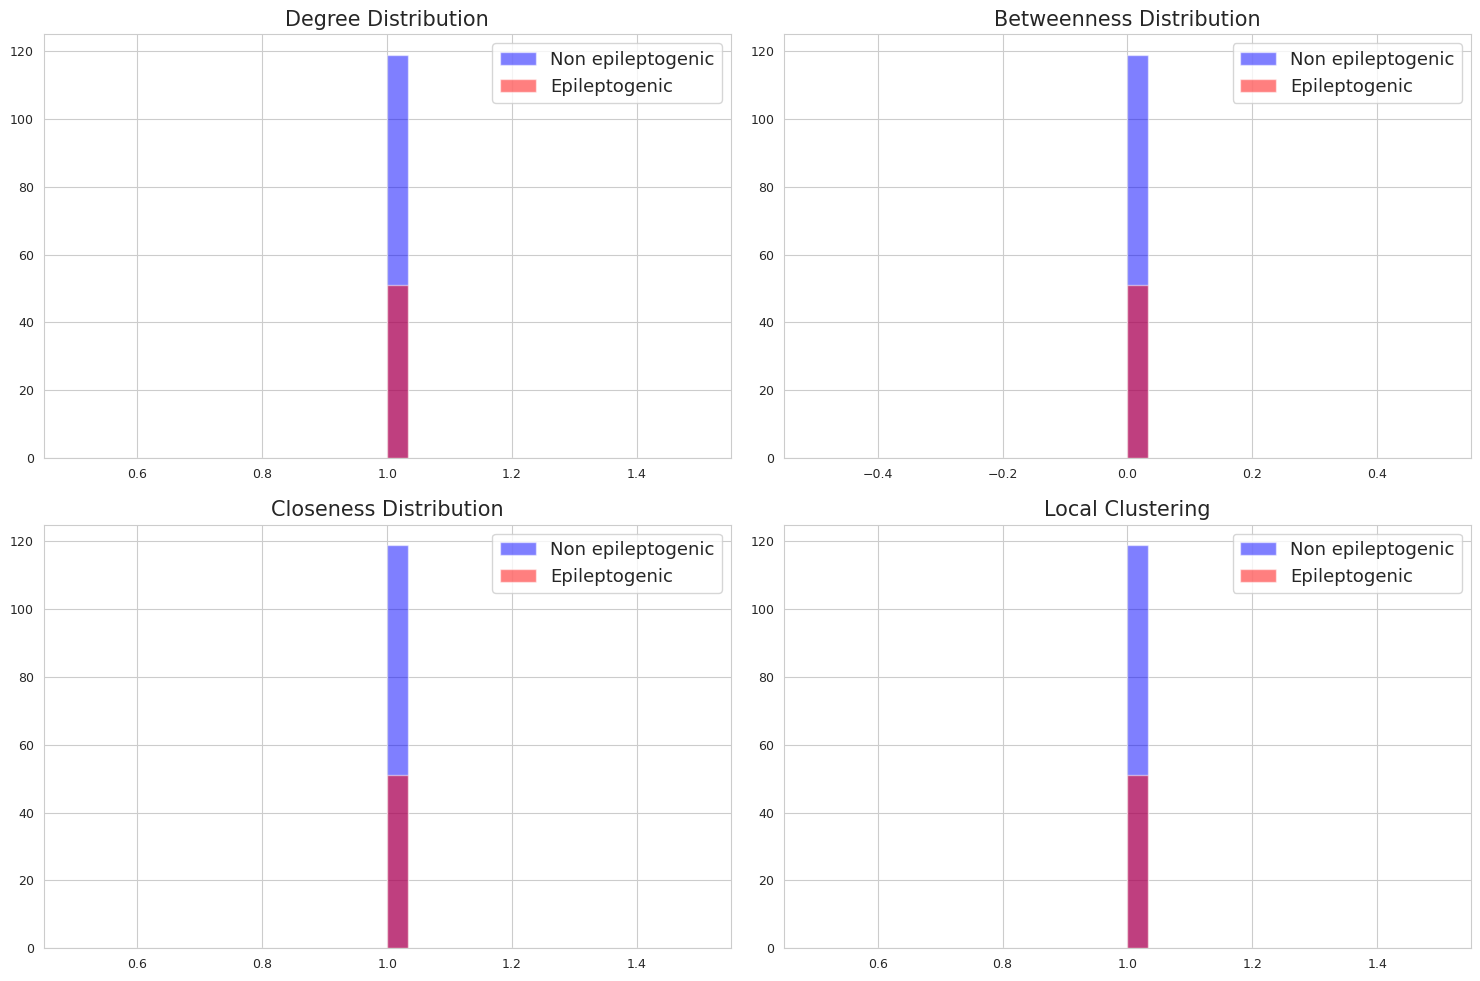

Betweenness   U Statistic: 0.5, p-value: 1.0
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.
Closeness   U Statistic: 0.5, p-value: 1.0
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.
Degree   U Statistic: 0.5, p-value: 1.0
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.
Local Clustering   U Statistic: 0.5, normalized p-value: 1.0
Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.


In [ ]:
new_matrix = adjacency_matrix
new_matrix[new_matrix < 0] = 0
G = nx.from_numpy_array(new_matrix)
nx.set_node_attributes(G, labels_dict, 'label')

centrality_values = {}
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
local_clustering = nx.clustering(G)

for node in G.nodes():
        label = G.nodes[node]['label']
        if label not in centrality_values:
        centrality_values[label] = {'Degree': [], 'Betweenness': [], 'Closeness': [], 'Local clustering': []}
        centrality_values[label]['Degree']=degree_centrality[node]
        centrality_values[label]['Betweenness']=betweenness_centrality[node]
        centrality_values[label]['Closeness']=closeness_centrality[node]
        centrality_values[label]['Local clustering']=local_clustering[node]

df = pd.DataFrame.from_dict(centrality_values, orient='index')
df.reset_index(inplace=True)
df.columns = ['Label', 'Degree', 'Betweenness', 'Closeness','Local Clustering']

print(df)

# Filtro i dati per label_0 e label_1
df_label_0 = df[df['Label'].isin(labels_0)]
df_label_1 = df[df['Label'].isin(labels_1)]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Degree Distribution
axs[0, 0].hist(df_label_0['Degree'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[0, 0].hist(df_label_1['Degree'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[0, 0].set_title('Degree Distribution')
axs[0, 0].legend()

# Betweenness Distribution
axs[0, 1].hist(df_label_0['Betweenness'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[0, 1].hist(df_label_1['Betweenness'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[0, 1].set_title('Betweenness Distribution')
axs[0, 1].legend()

# Closeness Distribution
axs[1, 0].hist(df_label_0['Closeness'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[1, 0].hist(df_label_1['Closeness'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[1, 0].set_title('Closeness Distribution')
axs[1, 0].legend()

# Distribuzione combinata di Degree, Betweenness e Closeness
axs[1, 1].hist(df_label_0['Local Clustering'], bins=30, alpha=0.5, label='Non epileptogenic', color='blue')
axs[1, 1].hist(df_label_1['Local Clustering'], bins=30, alpha=0.5, label='Epileptogenic', color='red')
axs[1, 1].set_title('Local Clustering')
axs[1, 1].legend()

plt.tight_layout()
plt.show()



#------------------------------------------------


n1 = len(df_label_0['Local Clustering'])
n2 = len(df_label_1['Local Clustering'])

u_stat_b, p_value_b = mannwhitneyu(df_label_0['Betweenness'], df_label_1['Betweenness'])
u_statistic_normalized_b=u_stat_b/(n1*n2)
print(f"Betweenness   U Statistic: {u_statistic_normalized_b}, p-value: {p_value_b}")
if u_statistic_normalized_b < 0.3 or u_statistic_normalized_b>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")

u_stat_c, p_value_c = mannwhitneyu(df_label_0['Closeness'], df_label_1['Closeness'])
u_statistic_normalized_c=u_stat_c/(n1*n2)
print(f"Closeness   U Statistic: {u_statistic_normalized_c}, p-value: {p_value_c}")
if u_statistic_normalized_c < 0.3 or u_statistic_normalized_c>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")

u_stat_s, p_value_s = mannwhitneyu(df_label_0['Degree'], df_label_1['Degree'])
u_statistic_normalized_s=u_stat_s/(n1*n2)
print(f"Degree   U Statistic: {u_statistic_normalized_s}, p-value: {p_value_s}")
if u_statistic_normalized_s < 0.3 or u_statistic_normalized_s>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")

u_stat_cl, p_value_cl = mannwhitneyu(df_label_0['Local Clustering'], df_label_1['Local Clustering'])
u_statistic_normalized_cl=u_stat_cl/(n1*n2)
print(f"Local Clustering   U Statistic: {u_statistic_normalized_cl}, normalized p-value: {p_value_cl}")
if u_statistic_normalized_cl < 0.3 or u_statistic_normalized_cl>0.7:
    print("Le due distribuzioni sono significativamente diverse.")
else:
    print("Non ci sono evidenze sufficienti per dire che le due distribuzioni sono diverse.")


In [ ]:
# Salvataggio del DataFrame in un file CSV
filename = f"Central measures_psd.csv"
percorso_completo = os.path.join(cartella, filename)
df.to_csv(percorso_completo, index=False)

# Clustering

Numero di cluster: 1


/tmp/ipykernel_320/2921883011.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cluster_colors = plt.cm.get_cmap('tab20', len(unique_clusters))  # Usa una mappa di colori predefinita con colori distinti


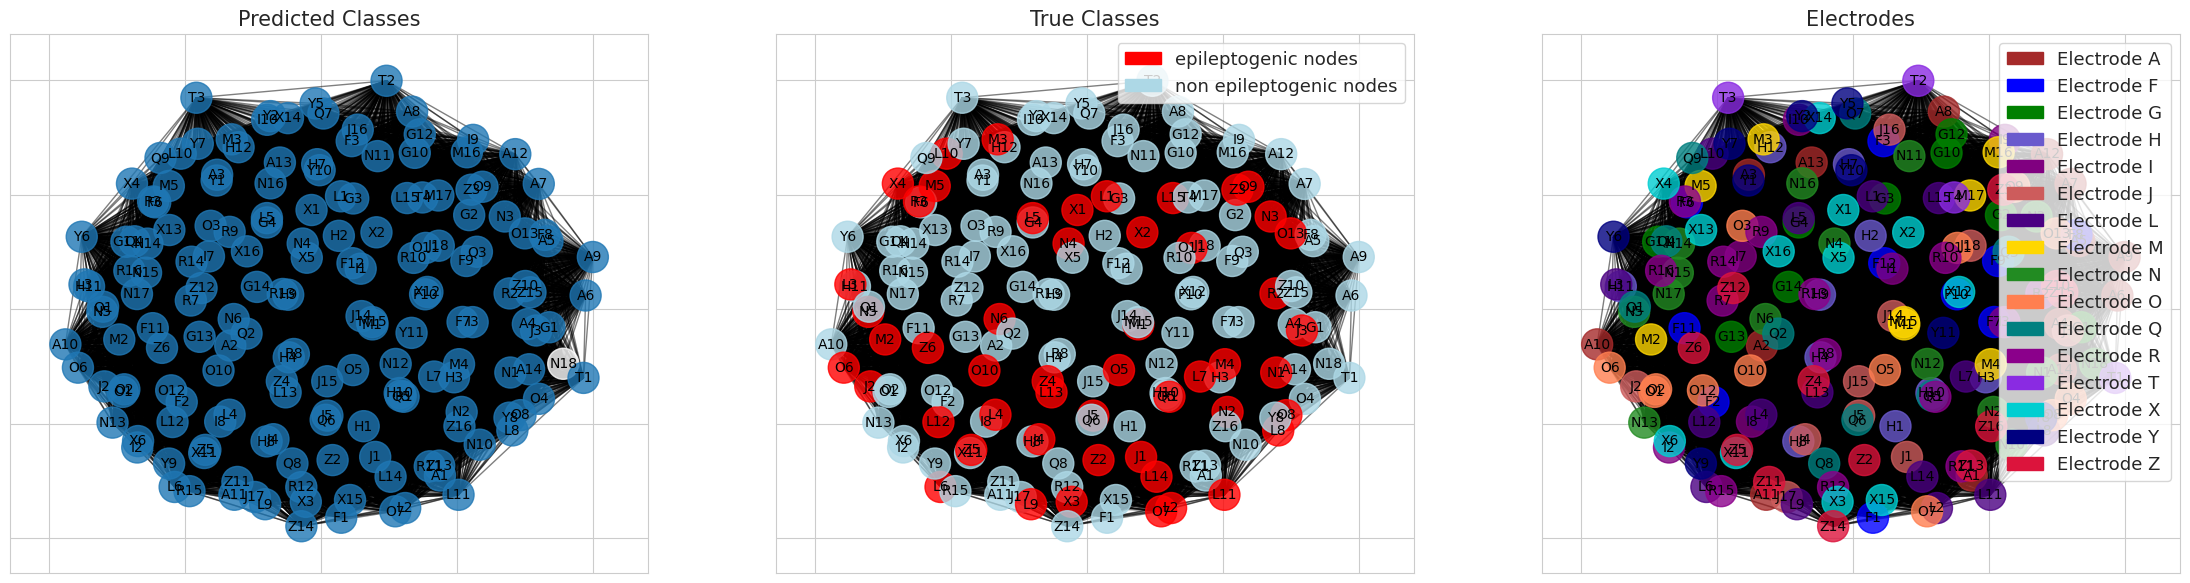


V Score classes vs clusters: 0.000
V Score classes vs electrode: 0.176
V Score cluster vs electrode: 0.000


In [ ]:
partitions=[]
partitions_labels=[]
homogeneity_scores1 = []
homogeneity_scores2 = []
homogeneity_scores3 = []
ari_scores1 = []
ari_scores2 = []
ari_scores3 = []
v_scores1 = []
v_scores2 = []
v_scores3 = []
filtered_partitions=[]


partition = community_louvain.best_partition(G,resolution=0.8)
# Filtrare i cluster con meno di 5 elementi
filtered_partition = {node: cluster_id for node, cluster_id in partition.items() if list(partition.values()).count(cluster_id) > 10}
filtered_partitions.append(filtered_partition)

cls = {}
for node, cluster_id in filtered_partition.items():
    if cluster_id not in cls:
        cls[cluster_id] = []
    cls[cluster_id].append((node, labels_tot[node]))

non_clustered_nodes = [node for node in partition if node not in filtered_partition]
clustered_nodes = [node for node in partition if node in filtered_partition]

# print(f"Nodi non compresi in nessun cluster di filtered_partition {len(non_clustered_nodes)}: {non_clustered_nodes}")
# print(f"Nodi compresi nei cluster di filtered_partition {len(clustered_nodes)}:{clustered_nodes}")
# for node in non_clustered_nodes:
#     print(non_clustered_nodes)
#     print(labels_tot[node])

labels_pred = [f"{filtered_partition[node]}" for node in range(len(labels_tot)) if node in filtered_partition]
num_clusters = len(cls)
print(f"Numero di cluster: {num_clusters}")

#---------------------------------------GRAFICO------------------------------------
plt.figure(figsize=(28, 7))
# Layout del grafo
seed_value = 42
pos = nx.spring_layout(G, seed=seed_value)


# Assegno un colore a ciascun cluster
plt.subplot(131)
unique_clusters = list(set(filtered_partition.values()))
cluster_colors = plt.cm.get_cmap('tab20', len(unique_clusters))  # Usa una mappa di colori predefinita con colori distinti
cluster_color_map = {cluster_id: cluster_colors(i) for i, cluster_id in enumerate(unique_clusters)}
colors = []
for node in G.nodes():
    if node in filtered_partition:
        cluster_id = filtered_partition[node]
        colors.append(cluster_color_map[cluster_id])  # Colore in base al cluster
    else:
        colors.append('white')


nx.draw_networkx_nodes(G, pos, node_size=500, node_color=colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))}, font_size=10)
plt.title('Predicted Classes')

# Assegno un colore diverso alle due classi 0 e 1
plt.subplot(132)
plt.title('True Classes')
node_colors2 = []
for label in labels_tot:
    if label in labels_0:
        node_colors2.append('lightblue')
    elif label in labels_1:
        node_colors2.append('red')
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors2, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))},font_size=10)
epileptogenic_patch = mpatches.Patch(color='red', label='epileptogenic nodes')
non_epileptogenic_patch = mpatches.Patch(color='lightblue', label='non epileptogenic nodes')
plt.legend(handles=[epileptogenic_patch, non_epileptogenic_patch], loc='upper right')


# Assegno un colore a ciascun elettrodo
plt.subplot(133)
colors = {'A': 'brown', 'F': 'blue', 'G': 'green', 'H': 'slateblue', 'I': 'purple', 'J': 'indianred', 'L': 'indigo', 'M': 'gold',
          'N': 'forestgreen', 'O': 'coral', 'Q': 'teal', 'R': 'darkmagenta', 'T': 'blueviolet', 'X': 'darkturquoise', 'Y': 'navy', 'Z': 'crimson'}
labels = labels_tot
node_colors = [colors[label[0].upper()] if label[0].upper() in colors else 'white' for label in labels]
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels={i: labels_tot[i] for i in range(len(labels_tot))},font_size=10,font_color='black')
legend_elements = [mpatches.Patch(color=color, label='Electrode ' + letter) for letter, color in colors.items()]
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Electrodes')



nome_file=f'network_psd_all.jpg'
percorso_completo = os.path.join(cartella, nome_file)
plt.savefig(percorso_completo, format='jpg', dpi=300)
plt.show()
print()



#-------------------------------------V-MEASURE and homogeneity---------------------------------------

labels_true_filtered = [labels_true[node] for node in clustered_nodes]
labels_electrodes_less = [labels_electrodes[node] for node in clustered_nodes]

if len(non_clustered_nodes)<70:
    # CLASSI EPI-NON EPI vs CLUISTERS
    v_score1= v_measure_score(labels_true_filtered, labels_pred)
    #print(f'V Score classes vs clusters: {v_score1:.3f}')
    v_scores1.append(v_score1)

    homo1= homogeneity_score(labels_true_filtered, labels_pred)
    homogeneity_scores1.append(homo1)

    #CLASSI ELETTRODI VS EPI-NON EPI
    v_score2= v_measure_score( labels_true,labels_electrodes)
    # print(f'V Score electrodes vs epi/non epi: {v_score2:.3f}')
    v_scores2.append(v_score2)

    homo2= homogeneity_score(labels_true,labels_electrodes)
    homogeneity_scores2.append(homo2)


    #CLASSI ELETTRODI VS CLUSTERS
    v_score3= v_measure_score(labels_pred,labels_electrodes_less )
    # print(f'V Score electrodes vs clusters: {v_score3:.3f}')
    v_scores3.append(v_score3)

    homo3= homogeneity_score(labels_pred,labels_electrodes_less)
    homogeneity_scores3.append(homo3)

else:
    v_scores1.append(0)
    homogeneity_scores1.append(0)
    v_scores2.append(0)
    homogeneity_scores2.append(0)
    v_scores3.append(0)
    homogeneity_scores3.append(0)


print(f'V Score classes vs clusters: {v_score1:.3f}')
print(f'V Score classes vs electrode: {v_score2:.3f}')
print(f'V Score cluster vs electrode: {v_score3:.3f}')